# PCA applied on PBMC 10X 4k Dataset in order to reproduce results

## Import useful modules

In [1]:
!pip install scanpy
!pip install keras
!pip install tensorflow
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip3 install igraph
!pip3 install leidenalg
!pip install os
!pip install csv
!pip install random

In [2]:
from keras import layers
from keras.models import load_model, Model
from keras import backend as K
import numpy as np
import scanpy as sc
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from layers import ConstantDispersionLayer, SliceLayer, ColWiseMultLayer
import keras
from keras.layers import Layer
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics.pairwise import euclidean_distances
from scipy.optimize import linear_sum_assignment as linear_assignment
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import h5py

In [3]:
tf.__version__

'2.15.0'

In [4]:
keras.__version__

'2.15.0'

## Preprocessing

### Load dataset

Import dataset PBMC and check the data

In [5]:
filename="./dataset/10X_PBMC.h5"
with h5py.File(filename, 'r') as f :
    data_X=f['X'][:]
    data_Y=f['Y'][:]
    df_X=pd.DataFrame(data_X)
    df_Y=pd.DataFrame(data_Y)
    
df_X

,0,1,2,3,4,5,6,7,8,9,...,16643,16644,16645,16646,16647,16648,16649,16650,16651,16652
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4267,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,1.0,20.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4269,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df_Y.columns=['label']
df_Y["label"]=df_Y['label'].astype(str)
df_Y

,label
0,2
1,2
2,2
3,8
4,3
...,...
4266,6
4267,5
4268,7
4269,3


In [7]:
df_Y["label"].value_counts()

label
1    1292
2     702
3     606
4     459
5     450
6     332
7     295
8     135
Name: count, dtype: int64

In [8]:
data_ann=sc.AnnData(df_X)
data_ann

C:\Users\berth\anaconda3\Lib\site-packages\anndata\_core\anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\berth\anaconda3\Lib\site-packages\anndata\_core\anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 4271 × 16653

In [9]:
data_ann.obs=df_Y

### Filter data

On filtre les données de manière peu stricte

In [10]:
sc.pp.filter_genes(data_ann, min_counts=1)
sc.pp.filter_cells(data_ann, min_counts=1)

C:\Users\berth\anaconda3\Lib\site-packages\anndata\_core\anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [11]:
data_ann.raw = data_ann.copy()

In [12]:
data_ann

AnnData object with n_obs × n_vars = 4271 × 16653
    obs: 'label', 'n_counts'
    var: 'n_counts'

### Normalize and scale

In [13]:
#normalize
sc.pp.normalize_total(data_ann)

#compute size factor
data_ann.obs['size_factors'] = data_ann.obs.n_genes / np.median(data_ann.obs.n_genes)
#data_ann.obs['size_factors'] = 1.0

#log transform
sc.pp.log1p(data_ann)

In [14]:
#sc.pp.highly_variable_genes(data_ann, n_top_genes=2000, batch_key="label")
#sc.pl.highly_variable_genes(data_ann)

In [15]:
#sc.pp.scale(data_ann)

### Explore the result

In [16]:
data_ann.X

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.38010312, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [17]:
data_ann.n_vars

16653

In [18]:
data_ann.X

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.38010312, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [19]:
data_ann.var

,n_counts
0,9.0
1,622.0
2,240.0
3,12.0
4,108.0
...,...
16648,347.0
16649,79.0
16650,9.0
16651,15.0


In [20]:
data_ann.obs

,label,n_counts,size_factors
0,2,1738.0,0.451781
1,2,3240.0,0.842215
2,2,1683.0,0.437484
3,8,2318.0,0.602547
4,3,2983.0,0.775409
...,...,...,...
4266,6,6512.0,1.692748
4267,5,3292.0,0.855732
4268,7,8319.0,2.162464
4269,3,2932.0,0.762152


In [21]:
data_ann.raw.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## PCA

Let's study a little bit the PCA and evolution of the metrics with the number of components

In [26]:
sc.tl.pca(data_ann, n_comps=50, use_highly_variable=False)

<BarContainer object of 50 artists>

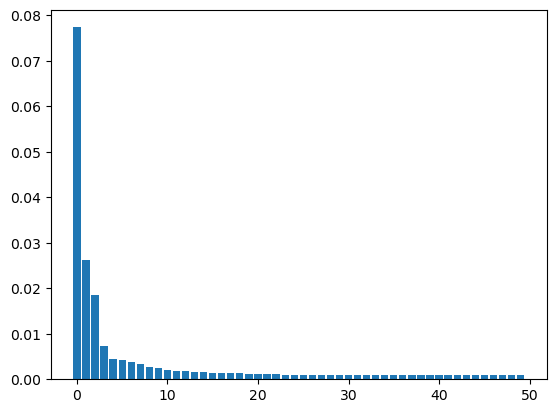

In [27]:
dim=[i for i in range (50)]
plt.bar(dim, data_ann.uns['pca']['variance_ratio'])

C:\Users\berth\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


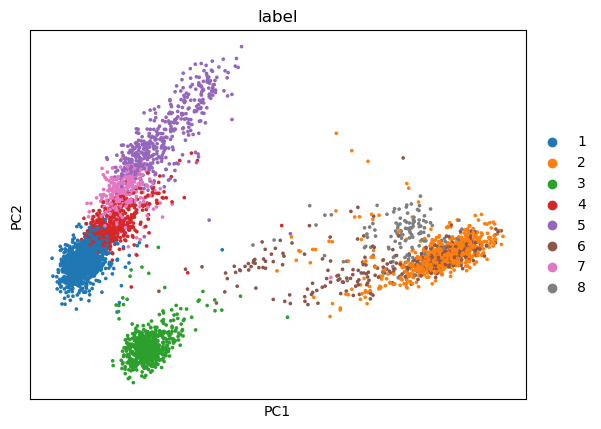

In [28]:
if len(dim)>1:
    sc.pl.pca(
    data_ann,
    color=["label"],
    dimensions=[(0, 1)],
)

In [29]:
def cluster_acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = np.asarray(y_true)
   
    y_pred = np.asarray(y_pred)
    
    #Make sure it's an array of str
    y_true= y_true.astype(str)
    y_pred = y_pred.astype(str)
    
    # find unique labels
    labels = np.unique(np.concatenate((y_true, y_pred)))
    n_labels = len(labels)

    # Build the confusion matrix (cost matrix)
    cost_matrix = np.zeros((n_labels, n_labels), dtype=int)
    for i, label_true in enumerate(labels):
        for j, label_pred in enumerate(labels):
            cost_matrix[i, j] = np.sum((y_true == label_true) & (y_pred == label_pred))

    #solve the optimal bipartite correspondance problem
    row_ind, col_ind = linear_assignment(cost_matrix.max() - cost_matrix)

    # Compute the accuracy
    accuracy = np.sum([cost_matrix[i, j] for i, j in zip(row_ind, col_ind)]) / y_true.size

    return accuracy

In [30]:
# Define the range of number of components
range_n_components = list(range(1, 21))  

#number of clusters for kmeans
n_clusters = 8 

#Initialize lists to save results
silhouette_scores = []
ari_score=[]
nmi_score=[]
ca_score=[]

for n in range_n_components:
    # Apply PCA
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(data_ann.X)

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=20)
    clusters = kmeans.fit_predict(X_pca)

    # Compute metric scores
    score = silhouette_score(X_pca, clusters)
    silhouette_scores.append(score)
    ari_score.append(adjusted_rand_score(data_ann.obs['label'], clusters))
    nmi_score.append(normalized_mutual_info_score(data_ann.obs['label'], clusters))
    ca_score.append(cluster_acc(data_ann.obs['label'], clusters))
    print(f'Nombre de composantes: {n}, Score de silhouette: {score}')

# what is the best number of components to maximize the silhouette score
best_n_components = range_n_components[np.argmax(silhouette_scores)]
print(f'Le meilleur nombre de composantes principales est: {best_n_components}')

Nombre de composantes: 1, Score de silhouette: 0.5678719894252944
Nombre de composantes: 2, Score de silhouette: 0.5418724011467702
Nombre de composantes: 3, Score de silhouette: 0.5273143050902565
Nombre de composantes: 4, Score de silhouette: 0.4413619745196498
Nombre de composantes: 5, Score de silhouette: 0.3577258156052196
Nombre de composantes: 6, Score de silhouette: 0.382760758748421
Nombre de composantes: 7, Score de silhouette: 0.425417509683824
Nombre de composantes: 8, Score de silhouette: 0.41947528105640647
Nombre de composantes: 9, Score de silhouette: 0.39663066418307713
Nombre de composantes: 10, Score de silhouette: 0.398231156711535
Nombre de composantes: 11, Score de silhouette: 0.38712924952524247
Nombre de composantes: 12, Score de silhouette: 0.37744512887294623
Nombre de composantes: 13, Score de silhouette: 0.36456062611000395
Nombre de composantes: 14, Score de silhouette: 0.3584984267806283
Nombre de composantes: 15, Score de silhouette: 0.35008653726001887
N

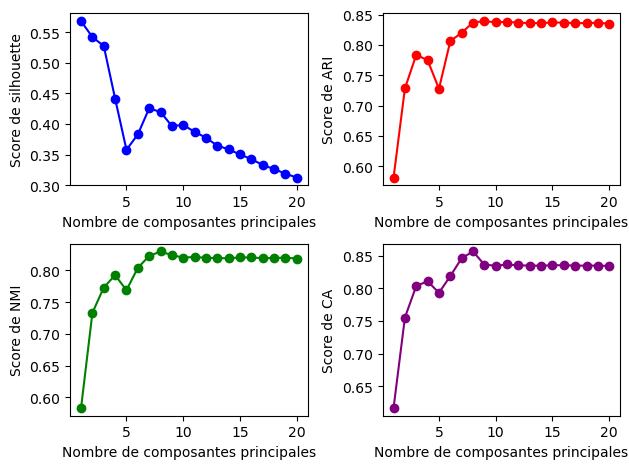

In [31]:
# plot the metric scores 
fig, axes = plt.subplots(2, 2)

# flatten the axis matrix
axes = axes.flatten()

axes[0].plot(range_n_components, silhouette_scores, marker='o', color='blue')
axes[0].set_xlabel('Nombre de composantes principales')
axes[0].set_ylabel('Score de silhouette')
#axes[0].set_title('Score de silhouette pour différents nombres de composantes principales')


axes[1].plot(range_n_components, ari_score, marker='o', color='red')
axes[1].set_xlabel('Nombre de composantes principales')
axes[1].set_ylabel('Score de ARI')
#axes[1].set_title('Score de ARI pour différents nombres de composantes principales')

axes[2].plot(range_n_components, nmi_score, marker='o', color='green')
axes[2].set_xlabel('Nombre de composantes principales')
axes[2].set_ylabel('Score de NMI')
#axes[2].set_title('Score de NMI pour différents nombres de composantes principales')

axes[3].plot(range_n_components, ca_score, marker='o', color='purple')
axes[3].set_xlabel('Nombre de composantes principales')
axes[3].set_ylabel('Score de CA')
#axes[3].set_title('Score de CA pour différents nombres de composantes principales')
plt.tight_layout()
plt.show()

The ARI, CA and NMI scores doesn't follow the same evolution as the silhouette score. In order to reproduce the same experiment, 1 component will be kept

In [32]:
sc.tl.pca(data_ann, n_comps=1, use_highly_variable=False)

<BarContainer object of 1 artists>

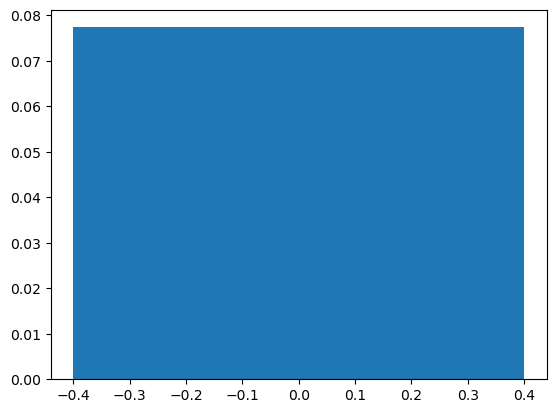

In [33]:
dim=[i for i in range (1)]
plt.bar(dim, data_ann.uns['pca']['variance_ratio'])

In [34]:
if len(dim)>1:
    sc.pl.pca(
    data_ann,
    color=["label"],
    dimensions=[(0, 1)],
)

In [35]:
def auto_kmeans( adata_latent, n="auto", plot=False):
    """
    Apply K-means clustering on the data to maximise the sum of the metrics
    
    Inputs :
        adata_latent : data after pca projection
        n : if auto, look for the best number of clusters otherwise use the n value given
        plot (bool) : if True show some plots, none otherwise
    
    Outputs :
        y_pred : clusters assignments from K-means clustering
        n (int) : the number of clusters 
        kmeans.cluster_centers_ : clusters centers
    """
    y=adata_latent.obs["label"]
    X_pca = adata_latent.obsm['X_pca']
    ari=[]
    nmi=[]
    ca=[]
    x=[]
    if n=="auto":
        #apply K-means for 1 to 20 clusters
        for n in range (1,20):
            kmeans = KMeans(n_clusters=n, random_state=0, n_init=30).fit(X_pca) 
            y_pred=kmeans.labels_.astype(str)
            ari.append(adjusted_rand_score(y, y_pred))
            nmi.append(normalized_mutual_info_score(y, y_pred))
            ca.append(cluster_acc(y, y_pred))
            x.append(n)
        #choose the number of clusters that maximize the sum of the metrics
        somme_metriques = [x + y + z for x, y, z in zip(ari, nmi, ca)]
        n_max=(somme_metriques.index(max(somme_metriques))+1)
    else: 
        n_max=n
        
    #compute for the selected value of n
    kmeans = KMeans(n_clusters=n_max, random_state=0, n_init=30).fit(X_pca) 
    y_pred=kmeans.labels_.astype(str)
    
    #display some plots if needed
    if plot==True:
        adata_latent.obs["kmeans"]=y_pred
        sc.pl.pca(adata_train,color=["label"],dimensions=[(0, 1)])
        sc.pl.pca(adata_train,color=["kmeans"],dimensions=[(0, 1)])
        plt.plot(x,ari)
        plt.plot(x,nmi)
        plt.plot(x,ca)
        plt.xlabel("nombre de clusters")
        plt.ylabel("Score")
        plt.legend(labels=["ARI", "NMI", "CA"])
        plt.plot()
    ari = adjusted_rand_score(y, y_pred)
    print("Indice de Rand ajusté (ARI) :", ari)
    nmi = normalized_mutual_info_score(y, y_pred)
    print("Normalized mutual info (NMI) :", nmi)
    ca=cluster_acc(y, y_pred)
    print("Clustering accuracy (CA) :", ca)
        
    return y_pred, n, kmeans

In [36]:
y_pred_train, n_clusters, kmeans=auto_kmeans( data_ann, n=8,  plot=False)

Indice de Rand ajusté (ARI) : 0.5811949291933077
Normalized mutual info (NMI) : 0.5826115804789677
Clustering accuracy (CA) : 0.6143760243502693


In [37]:
data_ann.obs

,label,n_counts,size_factors
0,2,1738.0,0.451781
1,2,3240.0,0.842215
2,2,1683.0,0.437484
3,8,2318.0,0.602547
4,3,2983.0,0.775409
...,...,...,...
4266,6,6512.0,1.692748
4267,5,3292.0,0.855732
4268,7,8319.0,2.162464
4269,3,2932.0,0.762152


Using exactly their way to do it 

In [38]:
x = np.array(data_ann.X)
y_true = np.array(data_ann.obs['label'])
pca = PCA(n_components=1)
x_pca = pca.fit(x).transform(x)

kmeans = KMeans(n_clusters=8, n_init=20)
y_pred = kmeans.fit(x_pca).labels_

#acc = np.round(cluster_acc(y_true, y_pred), 5)
nmi = np.round(normalized_mutual_info_score(y_true, y_pred), 5)
ari = np.round(adjusted_rand_score(y_true, y_pred), 5)
ca=np.round(cluster_acc(y_true, y_pred),5)
print('PCA + k-means result : NMI= %.4f, ARI= %.4f, CA = %.4f' % (nmi, ari, ca))


PCA + k-means result : NMI= 0.5795, ARI= 0.5643, CA = 0.6116


If we try to keep 8 components, the results are much better

In [39]:
x = np.array(data_ann.X)
y_true = np.array(data_ann.obs['label'])
pca = PCA(n_components=8)
x_pca = pca.fit(x).transform(x)

kmeans = KMeans(n_clusters=8, n_init=20)
y_pred = kmeans.fit(x_pca).labels_

#acc = np.round(cluster_acc(y_true, y_pred), 5)
nmi = np.round(normalized_mutual_info_score(y_true, y_pred), 5)
ari = np.round(adjusted_rand_score(y_true, y_pred), 5)
ca=np.round(cluster_acc(y_true, y_pred),5)
print('PCA + k-means result : NMI= %.4f, ARI= %.4f, CA = %.4f' % (nmi, ari, ca))


PCA + k-means result : NMI= 0.8290, ARI= 0.8363, CA = 0.8562
